In [1]:
import os,sys,subprocess,glob,importlib,pickle,itertools
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
import scipy,math

sys.path.append('../../../REA_with_CESM2')
from ensembles.ensemble_GKLT import ensemble_GKLT,get_weight_for_selection

sys.path.append('../../')
from experiment_configuration.experiment import experiment
from experiment_configuration.regions.region_by_slice import create_or_load_regional_mask, regional_average, shift_lon


def import_from(module, name):
    module = __import__(module, fromlist=[name])
    return getattr(module, name)

%load_ext autoreload
%autoreload 2

In [2]:
exp = experiment(import_from(f'experiment_configuration.c1', 'config'), online=False)

In [3]:
initial_conditions = exp.initial_conditions

In [4]:
initial_condition_tags = [ini.split('/')[-2].split('.fE.')[0].split('.')[-1] + '_' + ini.split('/')[-1][:4] for ini in initial_conditions]

In [5]:
data_path = "/work/bb1152/u290372/cesm215_archive/GKLT/initial_ssp370-2025_05-31"

In [6]:
regional_mask = create_or_load_regional_mask(
    regional_mask_file = f"/work/bb1152/u290372/GKLT/regions/wEU.nc",
    slice_lat=slice(44,55), 
    slice_lon=slice(-4,12),
    )

def preprocessor(nc):
    nc = shift_lon(nc)
    obs = nc['SOILWATER_10CM'][0]
    obs = regional_average(obs, regional_mask)
    return obs

In [7]:
mrsos = []
for ini_name, ini_tag in zip(initial_conditions, initial_condition_tags):
    with xr.open_mfdataset(f"{data_path}/{ini_tag}/lnd/hist/{ini_tag}.clm2.h7.{ini_tag.split('_')[1]}-06-01-00000.nc", preprocess=preprocessor) as nc:
        mrsos.append(nc['SOILWATER_10CM'].load())

In [10]:
mrsos = xr.concat(mrsos, dim="sim")
mrsos = mrsos.assign_coords(sim = initial_conditions)

In [15]:
dry_selection = mrsos.sortby(mrsos)[:10]
dry_selection

<xarray.DataArray 'SOILWATER_10CM' (sim: 10)> Size: 40B
array([25.801521, 26.982443, 27.03402 , 27.183079, 28.235723, 28.288605,
       28.652754, 28.76875 , 28.921074, 29.00213 ], dtype=float32)
Coordinates:
    time     (sim) object 80B 2024-06-01 00:00:00 ... 2024-06-01 00:00:00
  * sim      (sim) <U151 6kB '/work/bb1445/u290372/cesm215_archive/BSSP370cmi...

In [12]:
dry_selection.sim.values

array(['/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens020.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.1200.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens009.fE.2020.ens000/2025-01-01_to_2025-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens016.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.001.2005.ens018.fE.2020.ens000/2025-01-01_to_2025-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP370cmip6_current_2021-2031/b.e215.BSSP370cmip6.f09_g17.1400.fE.2020.ens000/2024-01-01_to_2024-05-31',
       '/work/bb1445/u290372/cesm215_archive/BSSP3

In [14]:
wet_selection = mrsos.sortby(mrsos)[-10:]
wet_selection

<xarray.DataArray 'SOILWATER_10CM' (sim: 10)> Size: 40B
array([35.961075, 35.97778 , 36.223106, 36.293488, 36.54776 , 36.629517,
       36.765785, 37.093307, 37.243725, 37.259926], dtype=float32)
Coordinates:
    time     (sim) object 80B 2024-06-01 00:00:00 ... 2025-06-01 00:00:00
  * sim      (sim) <U151 6kB '/work/bb1445/u290372/cesm215_archive/BSSP370cmi...

In [ ]:
wet_selection.sim.values

(array([ 1.,  0.,  3.,  0.,  3.,  4.,  4.,  5.,  6., 12.,  5., 12., 14.,
        17., 10., 13.,  4.,  5.,  4.,  4.]),
 array([25.8015213 , 26.37444115, 26.94736099, 27.52028275, 28.09320259,
        28.66612244, 29.23904228, 29.81196213, 30.38488388, 30.95780373,
        31.53072357, 32.10364532, 32.67656326, 33.24948502, 33.82240295,
        34.39532471, 34.96824646, 35.5411644 , 36.11408615, 36.68700409,
        37.25992584]),
 <BarContainer object of 20 artists>)

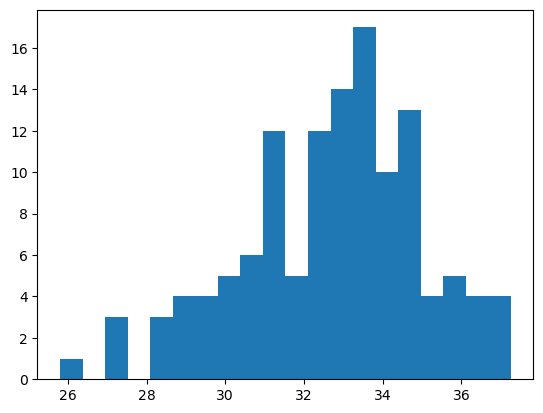

In [53]:
import matplotlib.pyplot as plt
plt.hist(mrsos, bins=20)